# Interpret video content using OpenAI and produce audio description

In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

In [2]:
#get key
openai.api_key = os.environ["OPENAI_API_KEY"]



Video loaded.
199 frames read.


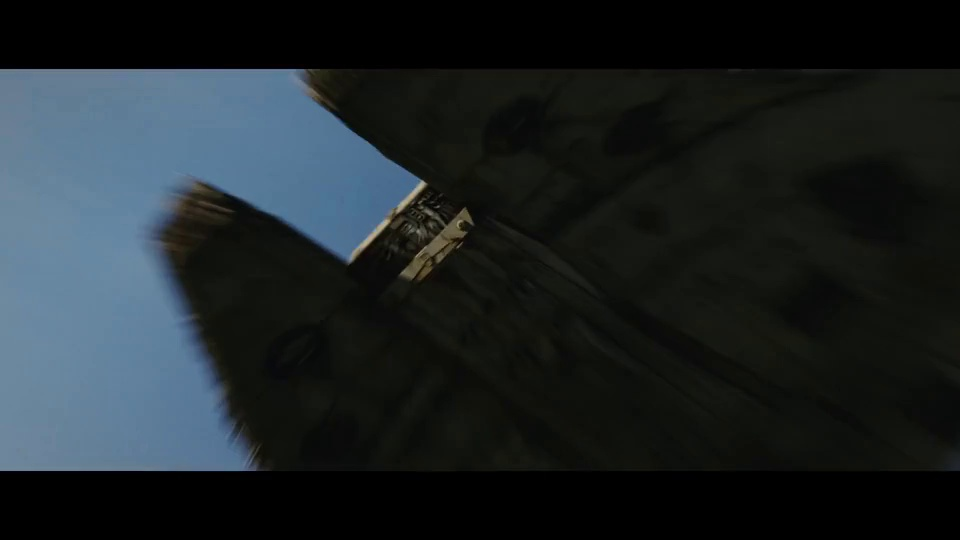

display_handle: <DisplayHandle display_id=385fdd5e8f32c8e94792818a59ed0522>


In [3]:
# choose from the following 3 videos
# oblivion_short(540p).mp4
# thor_short(540p).mp4
# sw_last_jedi_short(540p).mp4
video =cv2.VideoCapture("data/sw_last_jedi_short (540p).mp4")
print("Video loaded.")
base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

display_handle = display(None, display_id=True)
print(f'display_handle: {display_handle}')
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)




In [11]:

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = openai.chat.completions.create(**params)
print(result.choices[0].message.content)


PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}


TypeError: Completions.create() got an unexpected keyword argument 'headers'

In [17]:
result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

[Softly, almost a whisper]
Here, in the vastness of an otherworldly landscape, armored creatures of steel and fire streak across the horizon. Their bellies scrape the salty surface, gouging the terrain as they leave their mark—a vivid plume of red in stark contrast with the pale ground.

[A touch of wonder in the voice]
These mechanical beasts are not solitary; they move in unison, following an ancient call to action, their purpose woven into their very being. There is grace in their coordinated dance, a ballet set to the silent music of survival and resolve.

[Voice grows somber]
The quiet is broken by the sudden surge of energy. Inside their protective shells, pilots steel themselves for the challenge ahead. The calm of concentration etched onto their faces; a moment of tranquility amidst the brewing storm of conflict.

[Tension rises]
In the corridors of their metal refuge, there is movement and urgency. Figures dash with purpose—a symphony of preparation as the air thickens with an

In [18]:
# write audio to file
with open("voiceover.mp3", "wb") as f:
    f.write(audio)